raw文件读入

In [10]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

    
df_k = []
df_theta = []

for i in range(1,6):
    df_k.append(pd.read_csv(f'./raw_data/kz_{i}.csv'))
    df_theta.append(pd.read_csv(f'./raw_data/Theta_{i}.csv' ))
    
for i in range(5):
    print(f'kz_{i+1}.csv shape: {df_k[i].shape}')
    print(f'Theta_{i+1}.csv shape: {df_theta[i].shape}')
    
    
# 未解缠的 n_i
n_i = 1

num_rows = 804
num_cols = 2001


kz_1.csv shape: (804, 2001)
Theta_1.csv shape: (804, 2001)
kz_2.csv shape: (804, 2001)
Theta_2.csv shape: (804, 2001)
kz_3.csv shape: (804, 2001)
Theta_3.csv shape: (804, 2001)
kz_4.csv shape: (804, 2001)
Theta_4.csv shape: (804, 2001)
kz_5.csv shape: (804, 2001)
Theta_5.csv shape: (804, 2001)


重写用于打表的plot函数

In [115]:
from mpl_toolkits.mplot3d import Axes3D


def draw3D(H):
    N, M = H.shape
    x = np.linspace(1, M, M)
    y = np.linspace(1, N, N)
    x, y = np.meshgrid(x, y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, H, cmap='viridis')

    ax.set_title('Estimated Height')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height(m)')

    # Rotate view by 180 degrees
    ax.view_init(elev=10, azim=180)  # elev can be adjusted for better visualization

    plt.show()
    

def plot(*argv, titles=None):
  """
  plots a given number of phase maps
  """
  if len(argv) == 1:
    f, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 5))
    if titles is not None:
      ax.set_title(titles)
    a = ax.imshow(argv[0].squeeze(), cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(a, cax=cax)
    plt.show()
  else:
    f, axes = plt.subplots(1, len(argv), sharey=True, figsize=(10, 10))
    for i in range(len(argv)):
        if titles is not None:
          axes[i].set_title(titles[i])
        a = axes[i].imshow(argv[i].squeeze(), cmap='jet')
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(a, cax=cax)
    plt.show()
    f.colorbar(a, cax=cax)

def plot_hist(*argv, titles):
  """
  plots the historgram of the input phase maps
  """
  for i in range(len(argv)):
      hist = np.histogram(argv[i].ravel(), bins=100)
      plt.plot(hist[1][1:], hist[0])
  plt.xlabel("phase values")
  plt.ylabel("frequency")
  plt.title("Histogram Analysis")
  plt.grid()
  if titles is not None:
    plt.legend(titles)
  plt.show()  


In [63]:
def raw_pic(index):
    
    # 创建空数组存储计算结果
    results = np.zeros((num_rows, num_cols))
    
    # 遍历每个数据点，计算结果
    for i in range(num_rows):
        for j in range(num_cols):
            k_i = df_k[index].iloc[i, j]
            theta_i = df_theta[index].iloc[i, j]
            results[i, j] = -1 / k_i * (theta_i + 2 * math.pi * n_i)
            
    return results

# 原始数据打表

> 先跑一遍原始数据，将n置为0，在不还原高程的情况下看一下相位纠缠导致的结果

另外打一个关于 theta 和 k 的表，查看相位分布情况 与 K 和 raw图的关系

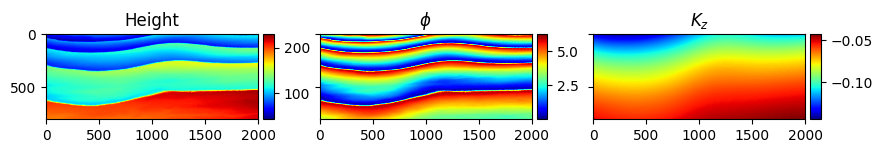

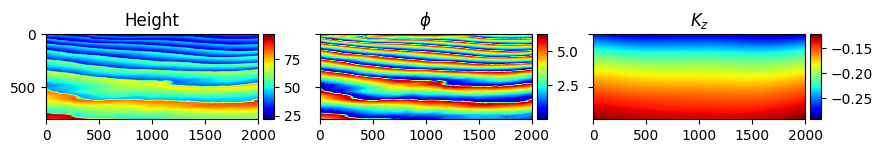

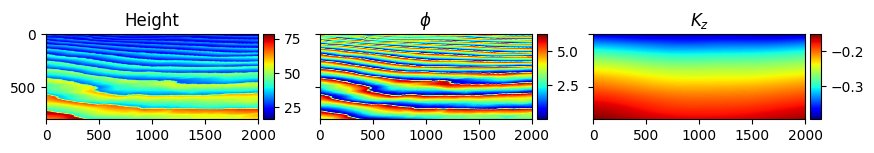

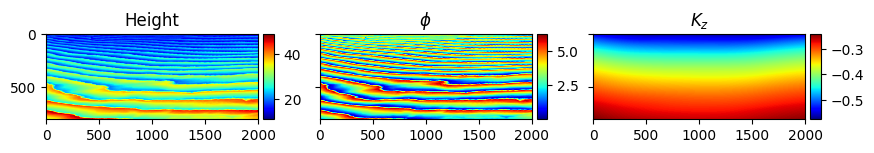

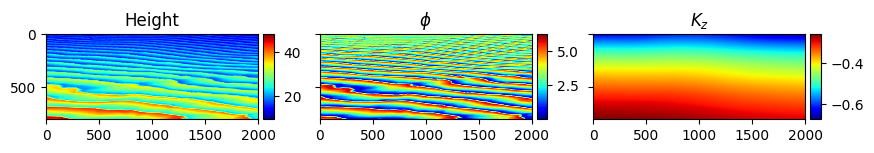

In [64]:
for i in range(5):
    plot(raw_pic(i), df_theta[i], df_k[i], titles=["Height", "$\phi$", "$K_z$"])

发现相位图与raw图在形式上是那啥的关系

基于连续性假设（相位展开）的解缠算法：

In [66]:
def unwrap_phase(theta):
    # 初始化 phi 矩阵
    phi = np.zeros_like(theta)
    phi[0, 0] = theta[0, 0]
    
    # 展开行
    for i in range(1, theta.shape[0]):
        delta = theta[i, 0] - theta[i-1, 0]
        delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
        phi[i, 0] = phi[i-1, 0] + delta_wrapped
    
    # 展开列
    for j in range(1, theta.shape[1]):
        delta = theta[0, j] - theta[0, j-1]
        delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
        phi[0, j] = phi[0, j-1] + delta_wrapped
    
    # 展开其余矩阵
    for i in range(1, theta.shape[0]):
        for j in range(1, theta.shape[1]):
            delta_row = theta[i, j] - theta[i-1, j]
            delta_col = theta[i, j] - theta[i, j-1]
            delta_row_wrapped = np.mod(delta_row + np.pi, 2 * np.pi) - np.pi
            delta_col_wrapped = np.mod(delta_col + np.pi, 2 * np.pi) - np.pi
            phi[i, j] = phi[i-1, j] + delta_row_wrapped
            phi[i, j] = phi[i, j-1] + delta_col_wrapped
    
    return phi


对第五组数据（考虑到raw图纠缠最复杂）输出3D高程图和2D高程图

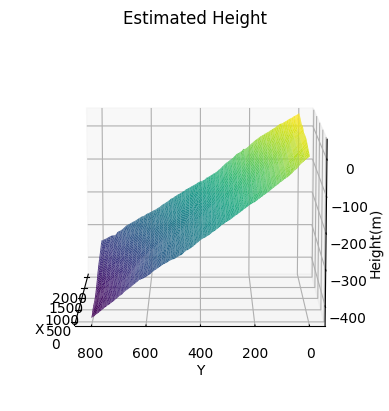

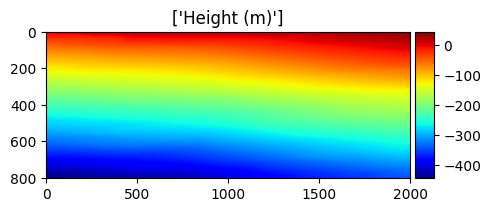

In [116]:
phi = unwrap_phase(np.array(df_theta[4]))

results = np.zeros((num_rows, num_cols))

# 遍历每个数据点，计算结果
for i in range(num_rows):
    for j in range(num_cols):
        k_i = df_k[4].iloc[i, j]
        results[i, j] = -1 / k_i * phi[i, j]

draw3D(results)

plot(results, titles=["Height (m)"])

发现解缠效果优秀，但是最后高程范围来到了负数，对此整体迭代添加周期，直至下限为150

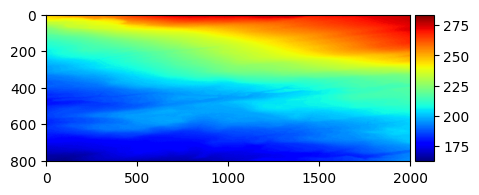

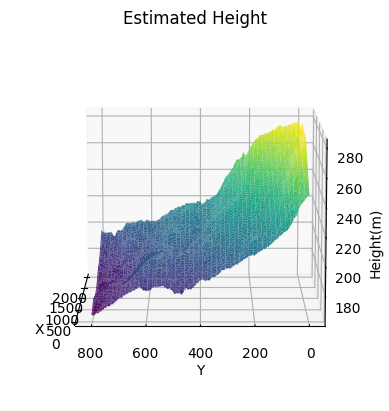

In [117]:
while np.min(results) < 150:
    results -= (2 * np.pi / df_k[4])
    
plot(results)
draw3D(results)

发现结果正好在题目给定范围内，对此做验证（1～4)组：

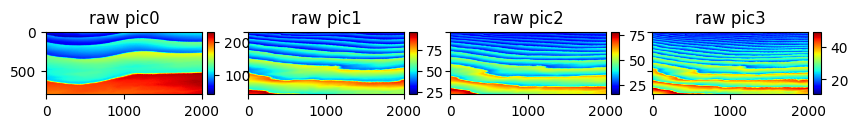

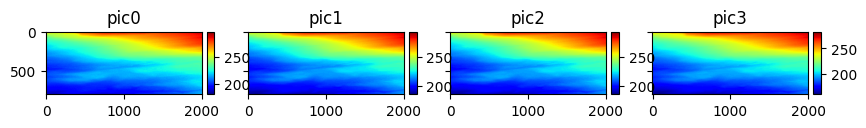

In [77]:
results = np.zeros((4, num_rows, num_cols))
for o in range(4):
    phi = unwrap_phase(np.array(df_theta[o]))
        
    for i in range(num_rows):
        for j in range(num_cols):
            k_i = df_k[o].iloc[i, j]
            results[o, i, j] = -1 / k_i * phi[i, j]
    
    while np.min(results[o]) < 150:
        results[o] -= (2 * np.pi / df_k[o])
  
plot(raw_pic(0), raw_pic(1), raw_pic(2), raw_pic(3), titles=[f"raw pic{i}" for i in range(4)])      
plot(results[0], results[1], results[2], results[3], titles=[f"pic{i}" for i in range(4)])


这里使用numpy自带的解缠方法对两个轴向上进行解缠分别查看效果（以第五组为例）

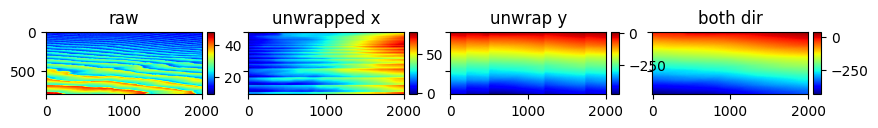

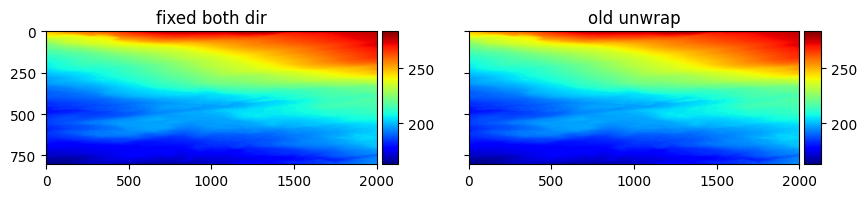

In [83]:
theta = np.array(df_theta[4]) 
k4 = np.array(df_k[4])

# 使用numpy的unwrap函数对theta进行处理
# 默认情况下，unwrap会沿着最后一个轴处理，对于二维矩阵来说，就是沿着每一行处理
# 如果你想沿着其他轴处理，可以使用axis参数
phix = np.unwrap(theta, axis=1)
phiy = np.unwrap(theta, axis=0)
phi = np.unwrap(phix, axis=0)

results = np.zeros((3 ,num_rows, num_cols))

for i in range(num_rows):
    for j in range(num_cols):
        k_i = df_k[4].iloc[i, j]
        results[0, i, j] = -1 / k_i * phix[i, j]
        results[1, i, j] = -1 / k_i * phiy[i, j]
        results[2, i ,j] = -1 / k_i * phi[i,j]


plot(raw_pic(4), results[0], results[1], results[2], titles=["raw" , "unwrapped x" ,"unwrap y", "both dir"])

while np.min(results[2]) < 150:
    results[2] -= (2 * np.pi / df_k[4])
        
results[0] = -1 / k4 * unwrap_phase(theta)
while np.min(results[0]) < 150:
    results[0] -= (2 * np.pi / df_k[4])
    
plot(results[2], results[0]  , titles=[ "fixed both dir", "old unwrap"])


可见两种方法得出的效果非常相近

自主模拟生产相位图 与 对应的纠缠图

In [107]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def simulate(size, m_1, m_2, C, A, mu_x, mu_y, sigma_x, sigma_y):
  """
  creates an arbitrary phase map by mixing gaussian blobs and adding ramps
  """
  x = np.arange(0, size[0], 1)
  y = np.arange(0, size[0], 1)
  xx, yy = np.meshgrid(x, y, sparse=True)
  I = np.zeros(size)
  ## mix randomly shaped and placed gaussian blobs
  
  for i in range(len(sigma_x)):
      a = (xx-mu_x[i])**2/(2*sigma_x[i]**2) + (yy-mu_y[i])**2/(2*sigma_y[i]**2)
      I += A[i]*np.exp(-a)
  ## add ramp phase with random gradients and shifts
  I = m_1*xx + m_2*yy + C + 0.1*I
  return I

def wrap(phi):
  """
  wraps the true phase signal within [-pi, pi]
  """
  return np.angle(np.exp(1j*phi))

def rescale(im, range):
  """
  mini-max rescales the input image
  """
  im_std = (im - im.min()) / (im.max() - im.min())
  im_scaled = im_std * (range[1] - range[0]) + range[0]
  return im_scaled

def create_random_image(size):
  """
  creates an randomly simulated true phase map
  """ 
  array_len = np.random.randint(2, 5)
  m = np.random.uniform(0, 0.5, [2])
  C = np.random.randint(1, 10)
  A = np.random.randint(50, 1000, array_len)
  mu_x = np.random.randint(round(size[0] / 4), round(size[1] * 3 / 4), array_len)
  mu_y = np.random.randint(round(size[0] / 4), round(size[1] * 3 / 4), array_len)
  sigma_x = np.random.randint(10, 45, array_len)
  sigma_y = np.random.randint(10, 45, array_len)
  I = simulate(size, m[0], m[1], C, A, mu_x, mu_y, sigma_x, sigma_y)
  return I



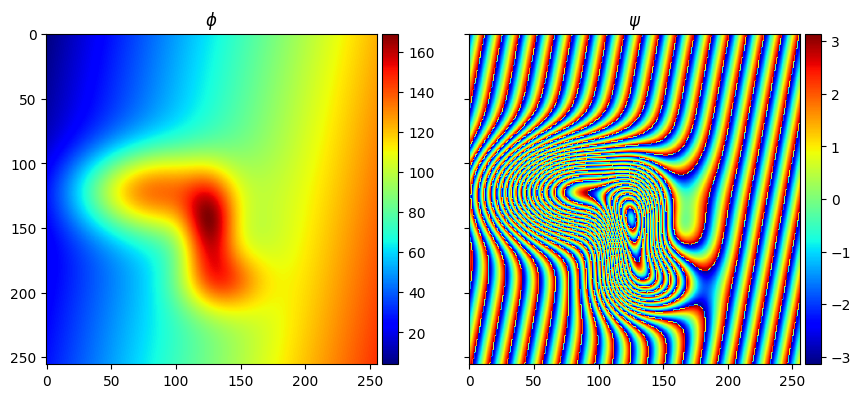

In [127]:
## example
size = (256, 256)

I = create_random_image(size)
I_wrap = wrap(I)
plot(I, I_wrap, titles=["$\phi$", "$\psi$"])

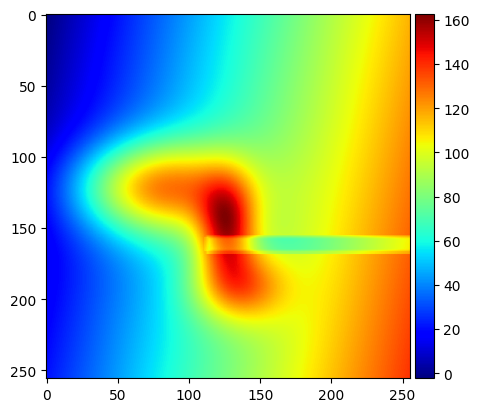

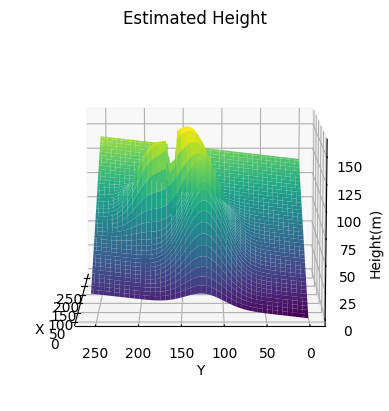

In [128]:
phi = unwrap_phase(I_wrap)

plot(phi)
draw3D(phi)

以上结果发现拟合效果不错能大体上解缠，但是依旧有一些区域无法完全解缠，故引入神经网络

以下是神经网络方法，训练过程参考tutorial

用自主模拟的相位图来训练一个模型，此处参考https://ieeexplore.ieee.org/document/9414748，使用它们的预训练模型，微调后接入我们的模型

In [ ]:
import numpy as np
import h5py
import os
import matplotlib as mpl
mpl.style.use('default')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras.layers import Activation, BatchNormalization, Conv2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.layers import MaxPooling2D, Dropout, Input, AveragePooling2D, Reshape, Permute, UpSampling2D
from keras.layers import SimpleRNN, Bidirectional, LSTM
from keras.layers import Lambda
from keras.models import load_model, Model
from keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

from keras.optimizers import *
import keras.backend as K
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
K.set_image_data_format('channels_last')

In [ ]:
def get_joint_conv_sqd_lstm_net():
    """
    Defines the joint convoltional and spatial quad-directional LSTM network
    """
    ## input to the network
    input = Input((256, 256, 1))

    ## encoder network
    c1 = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = AveragePooling2D()(c1)

    c2 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = AveragePooling2D()(c2)

    c3 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = AveragePooling2D()(c3)

    c4 = Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = AveragePooling2D()(c4)

    # SQD-LSTM Block
    x_hor_1 = Reshape((16 * 16, 128))(p4)
    x_ver_1 = Reshape((16 * 16, 128))(Permute((2, 1, 3))(p4))

    h_hor_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((16, 16, 64))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((16, 16, 64))(h_ver_1))

    c_hor_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    # decoder Network
    u5 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(H)
    u5 = concatenate([u5, c4])
    c5 = Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    u6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    ## output layer
    output = Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='out1')(c8)
    output = Activation('linear')(output)

    model = Model(inputs=[input], outputs=[output])
    return model


# 定义复合损失函数

由于我们将相位解包问题形式化为回归任务，因此损失函数的首选是均方误差（MSE）损失。然而，我们的实验显示，当将MSE损失应用于所提出的网络时，显示出不足的收敛性，导致相位解包性能不佳。从 $\psi = \angle e^{j\phi}$ 可知，$\phi + 2\pi n$ 其中 $\forall n \in \mathbb{Z}$ 导致相同的包裹相位 $\psi$。因此，$\psi$ 的相位解包问题没有唯一解。由于MSE损失强制网络学习一个唯一解，它并不适合相位解包问题的性质。因此，需要一个在收敛时允许其他解决方案同时增加预测相位 $\hat{\phi}$ 与真实相位 $\phi$ 之间相似性的损失函数。为了解决这些问题，我们采用了下面定义的复合损失函数 $\mathcal{L}_c$。

$$\mathcal{L}_c = \lambda_1 \mathcal{L}_{var} + \lambda_2 \mathcal{L}_{tv} $$
其中，
$$
    \mathcal{L}_{var} = \mathbb{E}\big[(\hat{\phi} - \phi)^2\big] - \big(\mathbb{E} \big[(\hat{\phi} - \phi) \big] \big)^2
$$
$$
    \mathcal{L}_{tv} = \mathbb{E}\big[|\hat{\phi}_x - \phi_x| + |\hat{\phi}_y - \phi_y|\big]
$$
并且 $\lambda_1$、$\lambda_2$ 是为两种损失分配的权重，在训练期间分别经验性地设置为1和0.1。误差方差损失 $\mathcal{L}_{var}$ 允许在收敛时有其他解决方案，而误差总变差损失 $\mathcal{L}_{tv}$ 通过强制网络匹配它们的梯度来增加 $\hat{\phi}$ 和 $\phi$ 之间的相似性。

重新加载模型

In [ ]:
model = get_joint_conv_sqd_lstm_net()
model_path = './model/LSTM_model.h5'
model.load_weights(model_path)

由于一开始加载了df_theta直接使用

In [130]:
X_test = df_theta

Y_pred = []
for i in range(5):
    Y_pred[i] = model.predict(X_test[i], batch_size = 4)


NameError: name 'model' is not defined

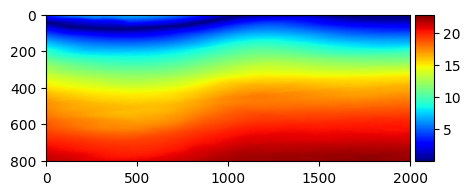

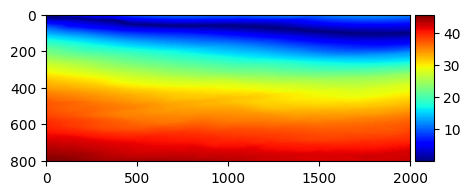

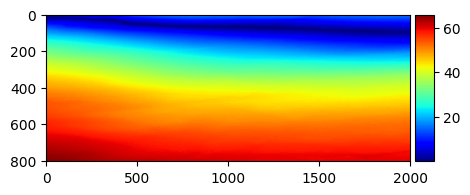

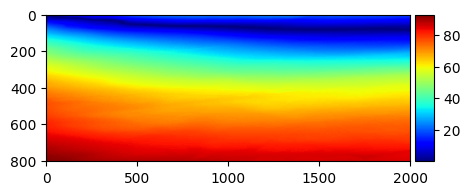

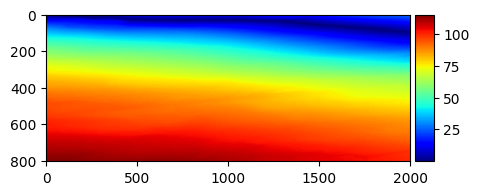

In [139]:
Y_pred = [unwrap_phase(np.array(df_theta[i])) for i in range(5)]

# 输出图像
for i in range(5):
    plot(np.abs(Y_pred[i]))

基于以上神经网络输出的 phi 我们求高程图

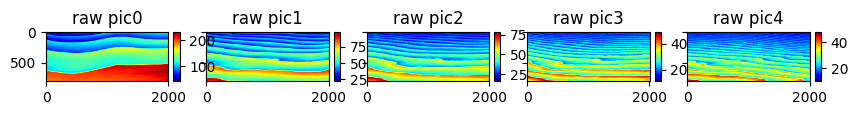

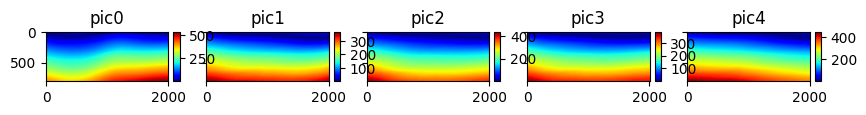

In [140]:
results = np.zeros((5, num_rows, num_cols))
for o in range(5):
    phi = np.abs(Y_pred[o])
        
    for i in range(num_rows):
        for j in range(num_cols):
            k_i = df_k[o].iloc[i, j]
            results[o, i, j] = -1 / k_i * phi[i, j]
    
    # while np.min(results[o]) < 150:
    #     results[o] -= (2 * np.pi / df_k[o])
  
plot(raw_pic(0), raw_pic(1), raw_pic(2), raw_pic(3), raw_pic(4), titles=[f"raw pic{i}" for i in range(5)])      
plot(results[0], results[1], results[2], results[3], results[4], titles=[f"pic{i}" for i in range(5)])


以上图片可以看到高程值并不在题目范围内，TODO